<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импортируем-библиотеки" data-toc-modified-id="Импортируем-библиотеки-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импортируем библиотеки</a></span></li><li><span><a href="#Загрузим-данные." data-toc-modified-id="Загрузим-данные.-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузим данные.</a></span></li><li><span><a href="#Выполним-ресемплирование-по-одному-часу" data-toc-modified-id="Выполним-ресемплирование-по-одному-часу-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Выполним ресемплирование по одному часу</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Предобработка-данных." data-toc-modified-id="Предобработка-данных.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Предобработка данных.</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Напишем-функцию-для-создания-дополнительных-признаков" data-toc-modified-id="Напишем-функцию-для-создания-дополнительных-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Напишем функцию для создания дополнительных признаков</a></span></li><li><span><a href="#Разделим-датасет-на-обучающую-и-тестовую-выборки" data-toc-modified-id="Разделим-датасет-на-обучающую-и-тестовую-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разделим датасет на обучающую и тестовую выборки</a></span></li><li><span><a href="#Обучим-модель-линейной-регрессии" data-toc-modified-id="Обучим-модель-линейной-регрессии-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучим модель линейной регрессии</a></span></li><li><span><a href="#Обучим-модель-DecisionTreeRegressor-с-различными-гиперпараметрами" data-toc-modified-id="Обучим-модель-DecisionTreeRegressor-с-различными-гиперпараметрами-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Обучим модель DecisionTreeRegressor с различными гиперпараметрами</a></span></li><li><span><a href="#Обучим-модель-LightGBM" data-toc-modified-id="Обучим-модель-LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Обучим модель LightGBM</a></span></li><li><span><a href="#Обучим-модель-CatBoost" data-toc-modified-id="Обучим-модель-CatBoost-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Обучим модель CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import time
import os
import warnings
import seaborn

from phik.report import plot_correlation_matrix
from phik import report


from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline
# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)
from sklearn.compose import ColumnTransformer
# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.dummy import DummyRegressor
#from optuna.integration import OptunaSearchCV 


# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")

RANDOM_STATE = 42

### Загрузим данные. 

In [2]:
pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    taxi_data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    taxi_data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')
    
taxi_data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Выполним ресемплирование по одному часу

Установим индекс таблицы равным столбцу Datetime, выполним сортировку и проверим, в хронологическом ли порядке расположены даты и время

In [3]:
taxi_data.sort_index(inplace=True)
print(taxi_data.index.is_monotonic_increasing) #после sort_index() индекс станет монотонным, если нет дублирующихся значений.
print(taxi_data.info())


True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [4]:
taxi_data = taxi_data.resample('1H').sum()

**Вывод: библиотеки импортированы, данные загружены, выполнено ресемплирование.**

## Анализ

### Предобработка данных.

Пропусков в данных нет из п.1.3.

Индекс монотонный, следовательно, не может быть дубликатов, проверка на дубликаты не нужна.

**Построим и проанализируем графики заказов, тренда и сезонности.**

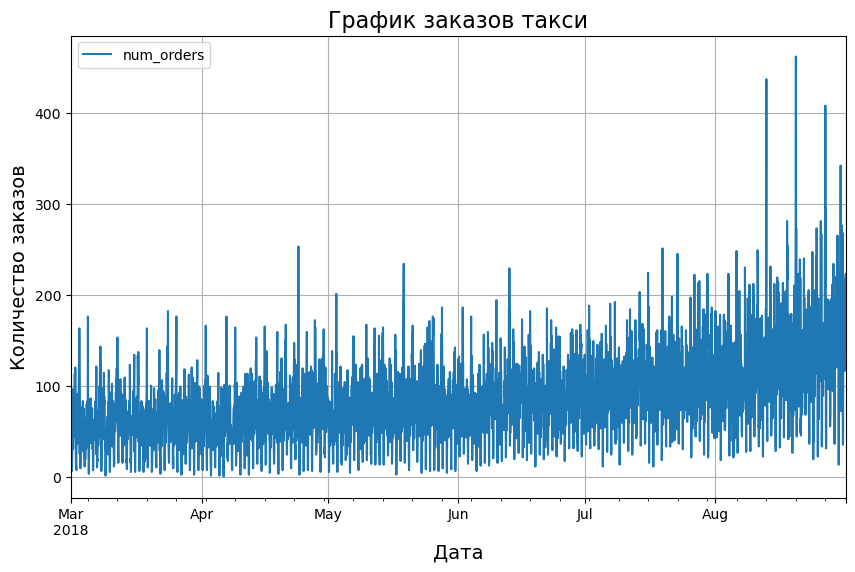

In [5]:
plt.figure(figsize=(10, 6))  
taxi_data.plot(ax=plt.gca())  

plt.title('График заказов такси', fontsize=16)
plt.xlabel('Дата', fontsize=14)  
plt.ylabel('Количество заказов', fontsize=14)  
plt.grid()
plt.legend()
plt.show()

In [6]:
decomposed_H = seasonal_decompose(taxi_data['2018-07-01':'2018-07-10'])
taxi_plot = taxi_data['2018-01':'2018-06'].resample('D').sum()
decomposed = seasonal_decompose(taxi_plot['2018-06':'2018-07']) 

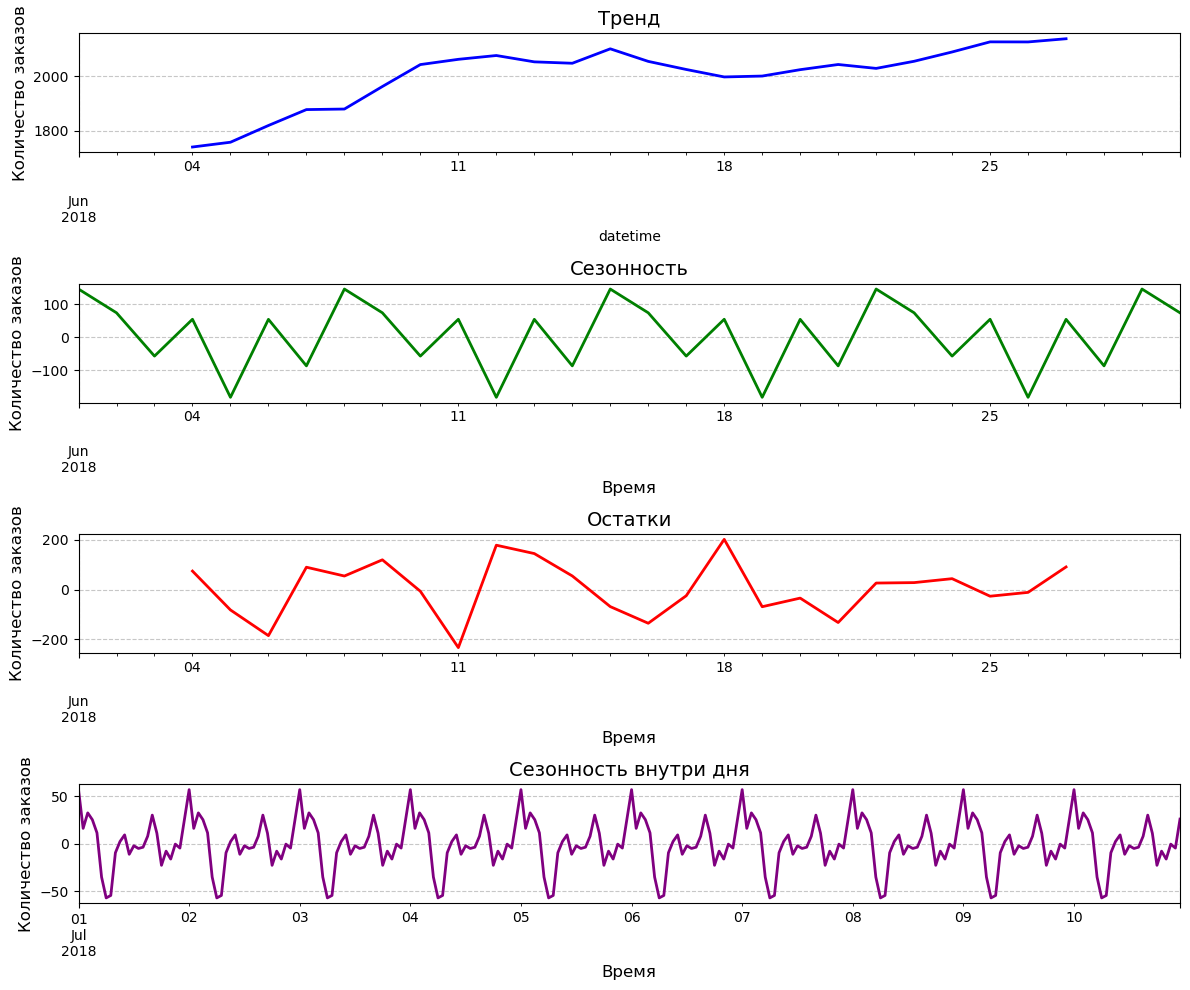

In [7]:
plt.figure(figsize=(12, 10))

# Первый график: Тренд
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca(), color='blue', linewidth=2)
plt.title('Тренд', fontsize=14)
plt.ylabel('Количество заказов', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Второй график: Сезонность
plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca(), color='green', linewidth=2)
plt.title('Сезонность', fontsize=14)
plt.ylabel('Количество заказов', fontsize=12)
plt.xlabel('Время', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Третий график: Остатки
plt.subplot(413)
decomposed.resid.plot(ax=plt.gca(), color='red', linewidth=2)
plt.title('Остатки', fontsize=14)
plt.ylabel('Количество заказов', fontsize=12)
plt.xlabel('Время', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Четвертый график: Сезонность внутри дня
plt.subplot(414)
decomposed_H.seasonal.plot(ax=plt.gca(), color='purple', linewidth=2)
plt.title('Сезонность внутри дня', fontsize=14)
plt.ylabel('Количество заказов', fontsize=12)
plt.xlabel('Время', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

Из графиков видно, что есть тренд на увеличение заказов, а сезонность есть внутри недели и внутри дня: внутри недели мы видим увеличение заказов к выходным и спад к будням, а внутри дня увеличение заказов вечером и спад ночью. Также на графике заказов видны выбросы, проанализируем их с помощью гистограммы и диаграммы размаха.

**Проверим временной ряд на стационарность, построив скользящее среднее за неделю.**

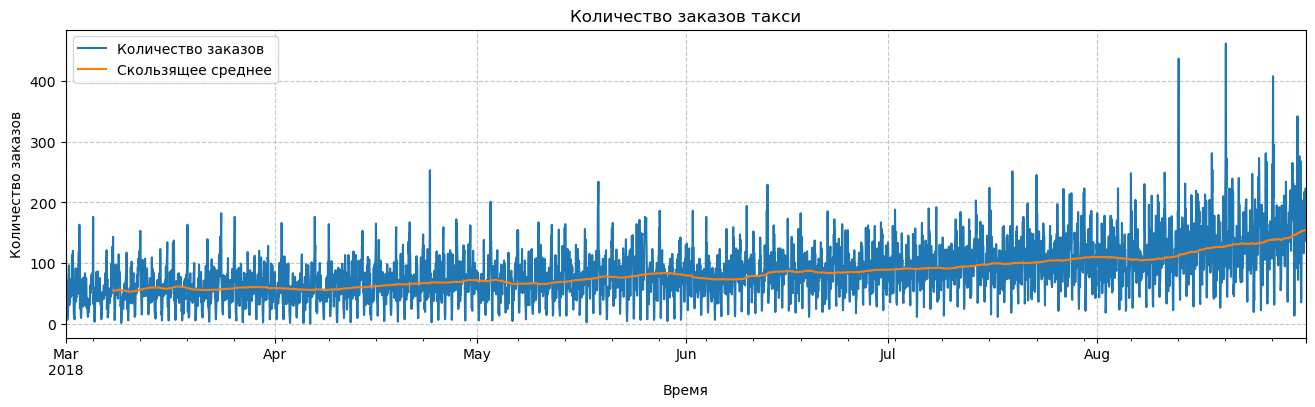

In [8]:
taxi_data['rolling_mean'] = taxi_data.shift(1).rolling(168).mean()

plt.figure(figsize=(16, 4))
taxi_data.plot(ax=plt.gca())
plt.title("Количество заказов такси")
plt.ylabel("Количество заказов") 
plt.xlabel("Время") 
plt.legend(["Количество заказов", "Скользящее среднее"])  
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Таким образом, ряд нестационарен.

**Построим гистограмму и диаграмму размаха числа заказов.**

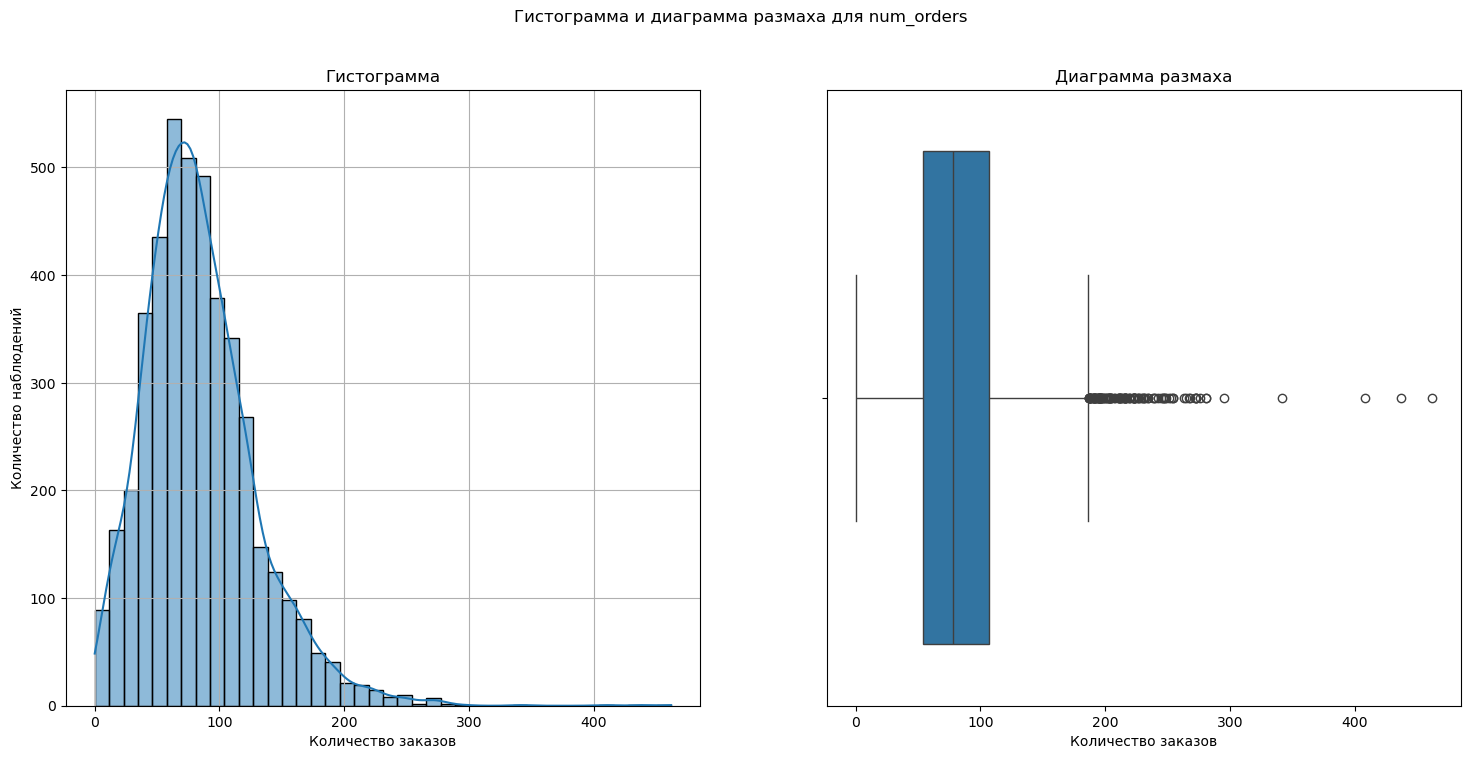

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64


In [9]:
fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (18,8))
sn.histplot(data = taxi_data,x = 'num_orders', color='#1f77b4', ax=axs[0], bins = 40, kde=True)
axs[0].set_xlabel('Количество заказов')
axs[0].set_ylabel('Количество наблюдений')
axs[0].set_title('Гистограмма')
axs[0].grid(True) 
sn.boxplot(data = taxi_data,x = 'num_orders', ax=axs[1], color='#1f77b4')
axs[1].set_xlabel('Количество заказов')
axs[1].set_title('Диаграмма размаха')
fig.suptitle(f'Гистограмма и диаграмма размаха для num_orders')
plt.show()
print(taxi_data['num_orders'].describe())

Оставим выбросы, они не выглядят некорректными.

**Вывод: Данные предобработаны, проанализированы тренд и сезонность. Найдены выбросы, но они не выглядят некорректными, поэтому их оставили.**

## Обучение

### Напишем функцию для создания дополнительных признаков

In [10]:
def make_features(data, max_lag): #, rolling_mean_size):

    data_new = data.copy()
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    data_new['lag_1'] = data_new['num_orders'].shift(1)
    data_new['lag_2'] = data_new['num_orders'].shift(2)
    data_new['lag_3'] = data_new['num_orders'].shift(3)
    data_new['lag_4'] = data_new['num_orders'].shift(4)
    data_new['lag_5'] = data_new['num_orders'].shift(5)
    data_new['lag_6'] = data_new['num_orders'].shift(6)
    data_new['lag_8'] = data_new['num_orders'].shift(8)
    data_new['lag_15'] = data_new['num_orders'].shift(15)
    data_new['lag_22'] = data_new['num_orders'].shift(22)
    data_new['lag_115'] = data_new['num_orders'].shift(115)
    data_new['lag_168'] = data_new['num_orders'].shift(168)
    #for lag in range(1,28,7):
    #    data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)   
    return data_new

По анализу трендов и сезонности выберем lag, равные 1, 3, 5, 7, 9, 11, 13, скользящее среднее за неделю rolling_mean_size=168 в датасете уже есть.

In [11]:
taxi_data_new = make_features(taxi_data, 7)
taxi_data_new.tail()

,num_orders,rolling_mean,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_8,lag_15,lag_22,lag_115,lag_168
datetime,,,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,154.297619,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,167.0,268.0,198.0,263.0,113.0
2018-08-31 20:00:00,154,154.434524,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,136.0,78.0,158.0,222.0,179.0
2018-08-31 21:00:00,159,154.285714,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,166.0,35.0,246.0,408.0,166.0
2018-08-31 22:00:00,223,154.244048,8,31,4,22,159.0,154.0,136.0,207.0,217.0,197.0,133.0,46.0,276.0,208.0,242.0
2018-08-31 23:00:00,205,154.130952,8,31,4,23,223.0,159.0,154.0,136.0,207.0,217.0,116.0,182.0,194.0,295.0,173.0


**Проведем корреляционный анализ признаков.**

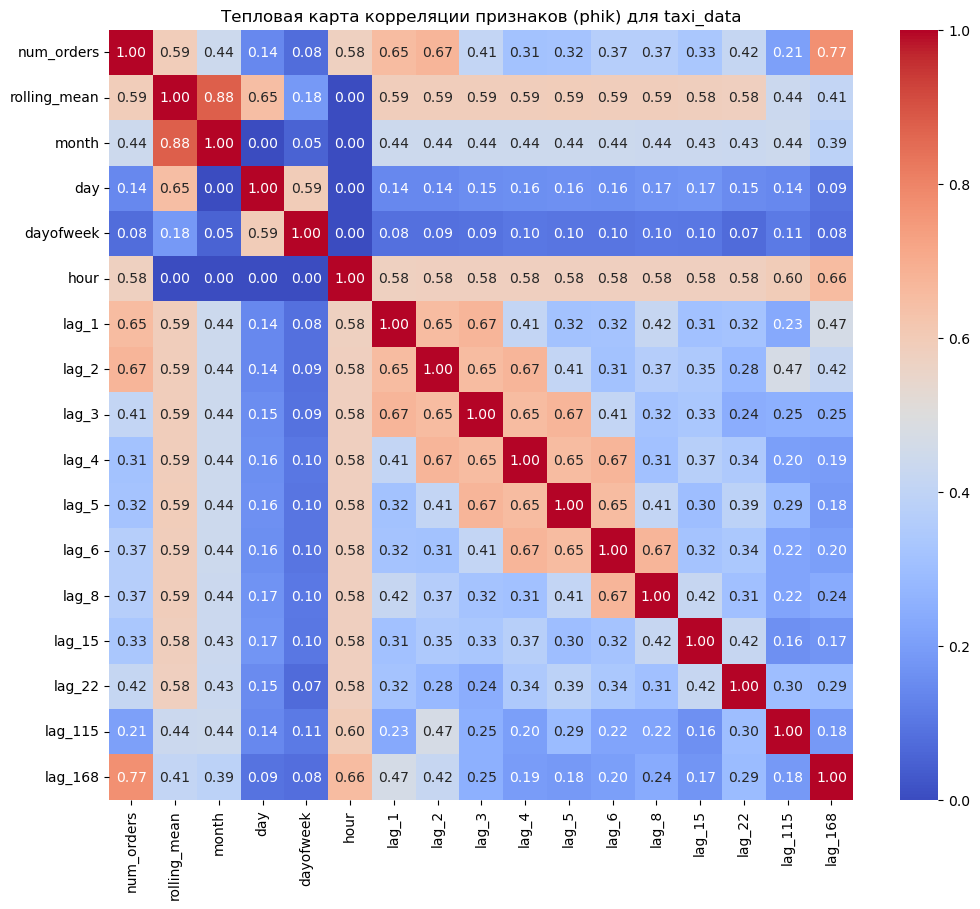

In [12]:
phik_corr = taxi_data_new.phik_matrix(interval_cols = ['lag_1','lag_2','lag_3','lag_4','lag_5','lag_6', 'lag_8','lag_15', 'lag_22','lag_115','lag_168','rolling_mean', 'num_orders']) 
plt.figure(figsize=(12, 10))
sn.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляции признаков (phik) для taxi_data')
plt.show()

Мультиколлинеарность отсутствует.

### Разделим датасет на обучающую и тестовую выборки

In [13]:
train, test = train_test_split(taxi_data_new, shuffle=False, test_size=0.1)
train = train.dropna()

y_train = train['num_orders']
X_train = train.drop(['num_orders'], axis = 1)

y_test = test['num_orders']
X_test = test.drop(['num_orders'], axis = 1)

### Обучим модель линейной регрессии

In [14]:
ohe_columns = [ 'month', 'day',  'dayofweek',  'hour' ]
num_columns = ['lag_1','lag_2','lag_3','lag_4','lag_5','lag_6', 'lag_8','lag_15' , 'lag_22', 'lag_115','lag_168','rolling_mean']

In [15]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
        
    ]
)

data_preprocessor = ColumnTransformer(
    [ 
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [16]:
tscv = TimeSeriesSplit(n_splits=3)

In [17]:
pipe_final_linear = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])

scores = cross_val_score(pipe_final_linear, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

print('Среднее значение RMSE:', -scores.mean())
print('Стандартное отклонение RMSE:', scores.std())


Среднее значение RMSE: 31.52816814041438
Стандартное отклонение RMSE: 6.638314851780542


Метрика модели LinearRegression при кросс-валидации: 32.6

### Обучим модель DecisionTreeRegressor с различными гиперпараметрами

In [18]:
ohe_columns = ['month', 'day',  'dayofweek',  'hour' ]
num_columns = ['lag_1','lag_2','lag_3','lag_4','lag_5','lag_6', 'lag_8','lag_15' ,'lag_22','lag_115','lag_168','rolling_mean']

In [19]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
        
    ]
)

data_preprocessor = ColumnTransformer(
    [ 
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [20]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [21]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 10),
        'models__max_features': range(10, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    } 
]

In [22]:
tscv = TimeSeriesSplit(n_splits=5)

In [23]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=Fals...
                                                                                'lag_168',
                                                                                'rolling_mean'])])),
                                             ('models',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(5, 10),
                                         'models__max_features': range(10, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [24]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', -randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['month', 'day', 'dayofweek',
                                                   'hour']),
                                                 ('num', MinMaxScaler(),
                          

Лучшей моделью DecisionTreeRegressor стала модель с гиперпараметрами max_depth=6, max_features=14. Метрика лучшей модели при кросс-валидации: 32.

### Обучим модель LightGBM

In [25]:
for column in ohe_columns:  #приведем категориальные столбцы к типу категория
    X_train[column] = X_train[column].astype('category') 
print(X_train[ohe_columns].dtypes)

month        category
day          category
dayofweek    category
hour         category
dtype: object


In [26]:
pipe_final_LGBM= Pipeline([
    ('models', LGBMRegressor(random_state=RANDOM_STATE))
])

In [27]:
param_distributions_LGBM = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [10, 20, 50],
        'models__max_depth': [3, 5, 7, 10]
    }
] 

In [28]:
randomized_search_LGBM = RandomizedSearchCV(
    pipe_final_LGBM, 
    param_distributions_LGBM,  
    scoring='neg_root_mean_squared_error',  
    cv=tscv, 
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

In [29]:
randomized_search_LGBM.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2392
[LightGBM] [Info] Number of data points in the train set: 3806, number of used features: 16
[LightGBM] [Info] Start training from score 79.352864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('models',
                                              LGBMRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LGBMRegressor(random_state=42)],
                                         'models__max_depth': [3, 5, 7, 10],
                                         'models__n_estimators': [10, 20, 50]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [30]:
print('Лучшая модель и её параметры:\n\n', randomized_search_LGBM.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', - randomized_search_LGBM.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 LGBMRegressor(max_depth=3, n_estimators=50, random_state=42))])
Метрика лучшей модели при кросс-валидации: 23.742915003847024


### Обучим модель CatBoost

In [31]:
param_distributions_CatBoost = [
    {
        'models': [CatBoostRegressor()],
        'models__iterations': range(500, 2000, 500),
        'models__depth': range(2, 10, 2),
        'models__verbose': [0]
    }
] 

In [32]:
pipe_final_CatBoost= Pipeline([
    ('models', CatBoostRegressor(random_state=RANDOM_STATE))
])

In [33]:
randomized_search_CatBoost = RandomizedSearchCV( #CatBoostRegressor
    pipe_final_CatBoost, 
    param_distributions_CatBoost, 
    cv=tscv,
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_CatBoost.fit(train.drop('num_orders', axis=1), train['num_orders'])

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('models',
                                              <catboost.core.CatBoostRegressor object at 0x000001ED162EF290>)]),
                   n_jobs=-1,
                   param_distributions=[{'models': [<catboost.core.CatBoostRegressor object at 0x000001ED1689E270>],
                                         'models__depth': range(2, 10, 2),
                                         'models__iterations': range(500, 2000, 500),
                                         'models__verbose': [0]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [34]:
best_model = randomized_search_CatBoost.best_estimator_.named_steps['models']

print('Лучшая модель и её параметры:\n\n', best_model.get_params())
print('Метрика лучшей модели при кросс-валидации:', -randomized_search_CatBoost.best_score_)

Лучшая модель и её параметры:

 {'loss_function': 'RMSE', 'verbose': 0, 'iterations': 1500, 'depth': 8}
Метрика лучшей модели при кросс-валидации: 24.419291099889882


LightGBM справился немного лучше, чем CatBoost.

In [35]:
model_results = pd.DataFrame({
    'Модель': ['Linear Regression', 'DecisionTreeRegressor', 'LightGBM', 'CatBoostRegressor'],
    'RMSE на обучающей выборке': [32.6, 32.5, 25.5, 26.1]
})
print(model_results.to_string(index=False))

               Модель  RMSE на обучающей выборке
    Linear Regression                       32.6
DecisionTreeRegressor                       32.5
             LightGBM                       25.5
    CatBoostRegressor                       26.1


**Вывод: Обучены 4 модели: Linear Regression, 
DecisionTreeRegresso,   LightGBM,    CatBoost. Линейная регрессия справилась лучше, чем дерево решений, вероятно, потому что она менее чувствительна к выбросам по сравнению с деревьями решений. Модели LightGBM  и CatBoostRegressor превзошли модель линейной регресии. Лучшей моделью стала модель LightGBM с параметрами max_depth=3, n_estimators=50 с метрикой 25.6. Ее и выберем для тестирования.**

## Тестирование

Протестируем лучшую модель.

In [36]:
for column in ohe_columns: #приведем категориальные столбцы к типу категория
    X_test[column] = X_test[column].astype('category') 
print(X_test[ohe_columns].dtypes)

month        category
day          category
dayofweek    category
hour         category
dtype: object


In [37]:
y_pred = randomized_search_LGBM.best_estimator_.predict(X_test)

In [38]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE тестовой выборки:", round(rmse,2))

RMSE тестовой выборки: 38.94


По условию значение метрики *RMSE* на тестовой выборке должно быть не больше 48, таким образом условие выполнено: RMSE тестовой выборки равно 37.43.

**Сравним теперь работу лучшей модели с DummyRegressor(), чтобы понять, насколько хорошо наша модель справляется с задачей по сравнению с простой базовой моделью, использующей среднее значение.**

In [39]:
dummy_regressor = DummyRegressor(strategy="mean")  # Использование стратегии "mean"
dummy_regressor.fit(X_train, y_train)

y_pred_dummy = dummy_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred_dummy)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Root Mean Squared Error (RMSE): 83.98


Разница существенная, модель LightGBM справляется значительно лучше DummyRegressor.

Визуализируем работу модели на тестовых данных.

In [40]:
taxi_data_pred = pd.DataFrame(y_pred)
taxi_data_pred['date'] = test.index
taxi_data_pred = taxi_data_pred.set_index('date')

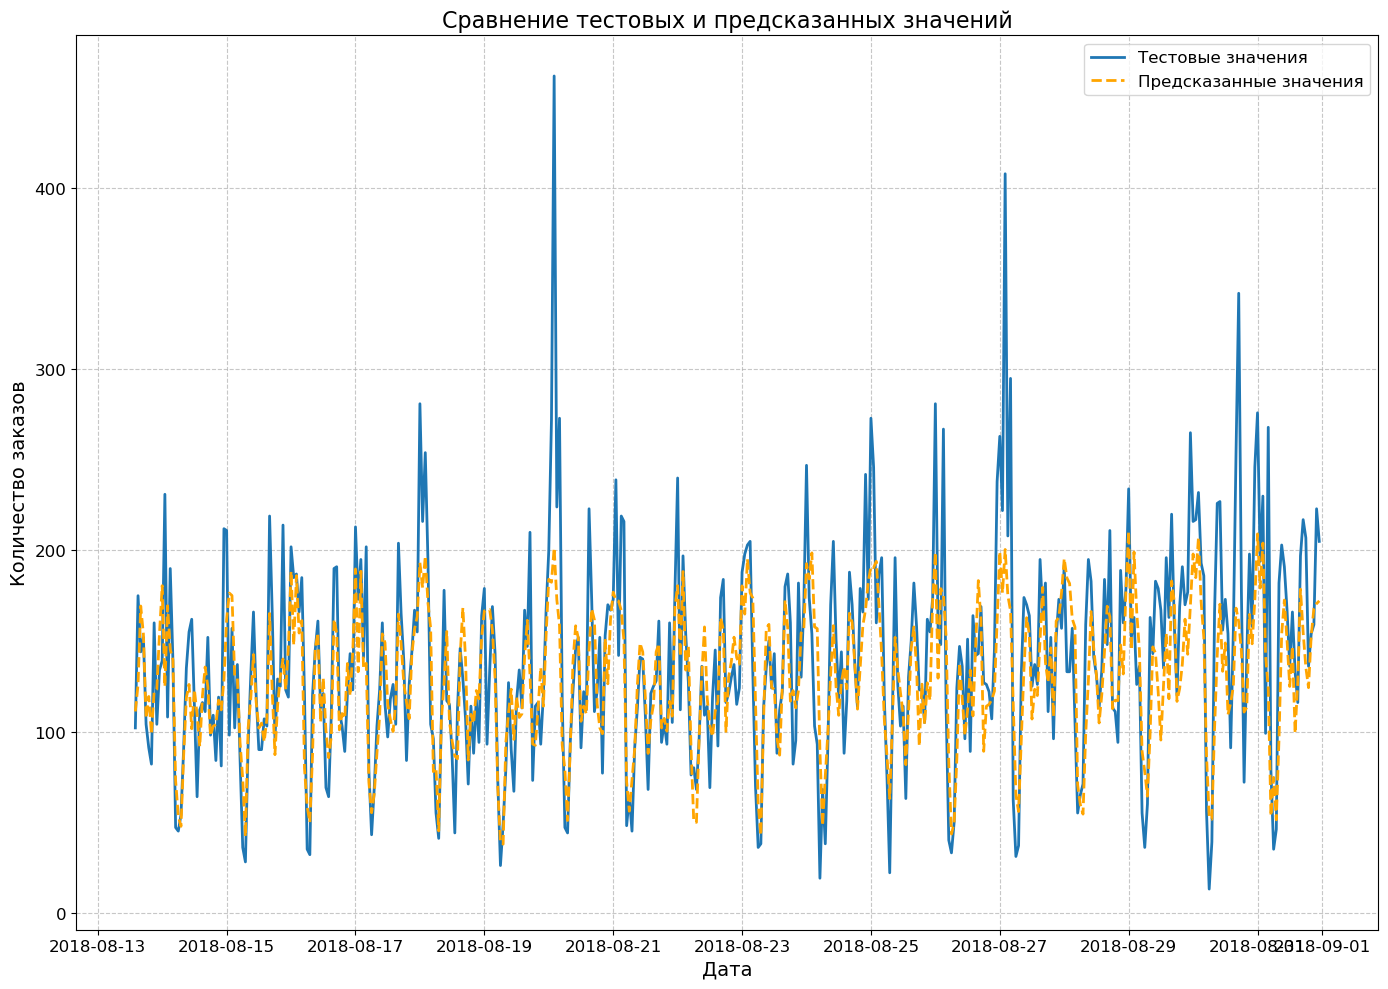

In [41]:
# Создаем график
fig, ax = plt.subplots(figsize=(14, 10))

ax.plot(test['num_orders'], label='Тестовые значения', color='#1f77b4', linestyle='-', linewidth=2)
ax.plot(taxi_data_pred, label='Предсказанные значения', color='orange', linestyle='--', linewidth=2)
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Количество заказов', fontsize=14)
ax.set_title('Сравнение тестовых и предсказанных значений', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

По графику видно, что модель сильнее всего ошибается на пиковых выбивающихся значения, скорее всего, это те значения, которые в диаграмме размаха выходили за пределы межквартильного диапазона. Модель хорошо предсказывает значения без сильных выбросов.

**Вывод: Перед нам стояла задача прогнозирования временного ряда заказов такси. Данные были предобработаны, проанализированы тренд и сезонность. Найден тренд на увеличение заказов, а также сезонность внутри недели и внутри дня: внутри недели мы видим увеличение заказов к выходным и спад к будням, а внутри дня увеличение заказов вечером и спад ночью.** 

**Модель LigthGBM с параметрами max_depth=5, n_estimators=50 на тестовой выборке показала метрику RMSE=43. Модель хорошо предсказывает почти все значения временного ряда, кроме пиковых.**